In [1]:
import pandas as pd

In [2]:
# Load Dataset
test_df = pd.read_csv('..\indexing\data\splitted_data\\v2\\test.csv')

In [3]:
test_df = pd.read_csv('..\indexing\data\splitted_data\\v2\\test.csv')

In [4]:
test_df.head()

,instansi,status,reference
0,kementerian agraria dan tata ruang/badan perta...,yes,kementerian agraria
1,kementerian agraria dan tata ruang/badan perta...,yes,kementerian tata ruang
2,kementerian agraria dan tata ruang/badan perta...,yes,kementerian badan pertanahan nasional
3,kementerian agraria dan tata ruang/badan perta...,yes,badan pertanahan nasional
4,kementerian agraria dan tata ruang/badan perta...,yes,atr


In [5]:
list_model = ['indobert-base-p1', 'indobert-base-p2']
INDEX = 0

In [6]:
import torch
import numpy as np
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('indobenchmark/{}'.format(list_model[INDEX]))
labels = {'no':0,
          'yes':1,
          }


In [7]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        
        self.labels = [labels[label] for label in df['status']]
        self.texts = [tokenizer(df['instansi'][i], df['reference'][i],
                               padding='max_length', max_length = 512, truncation=True, 
                               return_tensors="pt") for i in range(df.index[0],df.index[-1] + 1)]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [8]:
from torch import nn
from transformers import BertModel

In [9]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('indobenchmark/{}'.format(list_model[INDEX]))
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [10]:
model = torch.load('Models/{}'.format(list_model[INDEX]))

In [11]:
import torch.nn.functional as F

In [12]:
#Predict
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    probs = []
    preds = []

    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)
              prob = F.softmax(output, dim=1)
              pred = output.argmax(dim=1)
              probs.append(prob)
              preds.append(pred)

              #pred_class
              temp_pred = []
              for i in range(0,len(preds)):
                a = preds[i].cpu().numpy().tolist()
                temp_pred.append(a)
              list_pred = [x for y in temp_pred for x in y]
              
              #prob values
              temp_prob = []
              for i in range(0,len(probs)):
                a = probs[i].cpu().numpy().tolist()
                temp_prob.append(a)
              list_prob = [max(x) for y in temp_prob for x in y]


              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    new_test_data = test_data.copy()
    new_test_data['pred'] = list_pred
    new_test_data['prob'] = list_prob

    new_test_data = new_test_data[['reference', 'instansi', 'status', 'pred', 'prob']]

    return new_test_data
      
pred_result = evaluate(model, test_df)
pred_result.to_csv('result/hasil_prediksi_{}_sementara.csv'.format(list_model[INDEX]))

Test Accuracy:  0.923


In [13]:
pred_result

,reference,instansi,status,pred,prob
0,kementerian agraria,kementerian agraria dan tata ruang/badan perta...,yes,1,0.838313
1,kementerian tata ruang,kementerian agraria dan tata ruang/badan perta...,yes,1,0.938691
2,kementerian badan pertanahan nasional,kementerian agraria dan tata ruang/badan perta...,yes,1,0.994402
3,badan pertanahan nasional,kementerian agraria dan tata ruang/badan perta...,yes,1,0.994276
4,atr,kementerian agraria dan tata ruang/badan perta...,yes,1,0.830647
...,...,...,...,...,...
907,indofarma,pt indofarma,yes,1,0.996488
908,igm,pt indofarma,no,1,0.992995
909,kereta api,pt kereta api indonesia (persero) (kai),no,1,0.619621
910,pt perkapalan,pt dok dan perkapalan surabaya (persero),no,0,0.965213


In [14]:
pred_result[pred_result['reference']=="bpk"]

,reference,instansi,status,pred,prob
53,bpk,badan pemeriksa keuangan (bpk),yes,1,0.996363
88,bpk,badan pengelola keuangan haji (bpkh),no,1,0.991217


In [15]:
#Ambil hasil prediksi dengan nilai confidence tertinggi
lst_sinonim = pred_result['reference'].unique().tolist()

idx_to_take = []
for sinonim in lst_sinonim:
    df_sn = pred_result[pred_result['reference']==sinonim]
    df_sn = df_sn.drop_duplicates()
    if 1 in df_sn['pred'].values:
        df_sn_new = df_sn[df_sn['pred']==1]
        df_sn_new = df_sn_new.sort_values(by='prob', ascending=False)
        idx = df_sn_new.index.tolist()[0]
        idx_to_take.append(idx)
    elif 1 not in df_sn['pred'].values:
        df_sn_new = df_sn[df_sn['pred']==0]
        df_sn_new = df_sn_new.sort_values(by='prob', ascending=False)
        idx = df_sn_new.index.tolist()[0]
        idx_to_take.append(idx)

new_result_df = pred_result.loc[idx_to_take,:]
new_result_df

,reference,instansi,status,pred,prob
0,kementerian agraria,kementerian agraria dan tata ruang/badan perta...,yes,1,0.838313
1,kementerian tata ruang,kementerian agraria dan tata ruang/badan perta...,yes,1,0.938691
2,kementerian badan pertanahan nasional,kementerian agraria dan tata ruang/badan perta...,yes,1,0.994402
3,badan pertanahan nasional,kementerian agraria dan tata ruang/badan perta...,yes,1,0.994276
4,atr,kementerian agraria dan tata ruang/badan perta...,yes,1,0.830647
...,...,...,...,...,...
907,indofarma,pt indofarma,yes,1,0.996488
908,igm,pt indofarma,no,1,0.992995
909,kereta api,pt kereta api indonesia (persero) (kai),no,1,0.619621
910,pt perkapalan,pt dok dan perkapalan surabaya (persero),no,0,0.965213


In [16]:
#Confusion Matrix
from sklearn.metrics import accuracy_score,confusion_matrix

In [17]:
pred_result['status'] = pred_result['status'].map({"yes" : 1, "no" : 0})

In [18]:
label_true = pred_result['status'].values
prediction = pred_result['pred'].values

cf_matrix = confusion_matrix(label_true, prediction)

<AxesSubplot:>

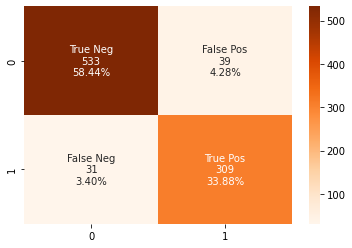

In [19]:
import seaborn as sns
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Oranges')